<a href="https://colab.research.google.com/github/danielhandong/Classification_images-/blob/main/TB_classification1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


In [2]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import csv
from tabulate import tabulate
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights, ResNet50_Weights, resnet50
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import optuna
from sklearn.model_selection import train_test_split
import os


In [3]:
#Data import
data_path = "/content/drive/MyDrive/TB_Chest_Radiography_Database"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


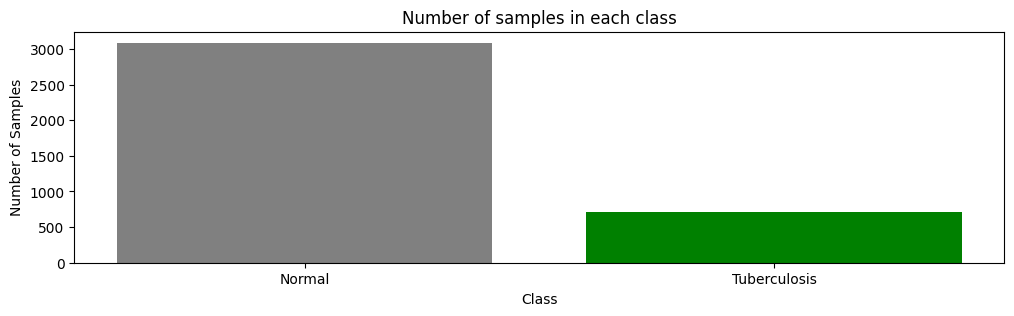

In [5]:
# class distribution

#Get the list of class folders in the dataset directory
class_folders = os.listdir(data_path)

#define colors for each class
class_colors = {"Healthy": "blue", "Tuberculosis": "green"}

#Count then number of images in each class and store in a dictionary
class_counts = {}
for folder in class_folders:
    class_path = os.path.join(data_path, folder)
    image_names = os.listdir(class_path)
    class_counts[folder] = len(image_names)

#plot a bar chart of the number of samples in each class with different colors for each class
plt.figure(figsize=(12,3))
plt.bar(class_counts.keys(), class_counts.values(), color=[class_colors[f] if f in class_colors else 'gray' for f in class_counts.keys()])
#plt.bar(class_counts.keys(), class_counts.values(), color=[class_colors[f] if f in class_counts.keys()])
plt.title("Number of samples in each class")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

In [ ]:
# import splitfolders
# # splitfolders.ratio(data_path, output="", seed=42, ratio=(.7,.3), group_prefix=None, move=False)
# splitfolders.fixed(data_path, output="/content/drive/MyDrive/split_data", seed=42, fixed=(200,100), oversample=True, group_prefix=None)

In [ ]:
# ! pip install  split-folders


In [6]:
import tensorflow as tf
img_shape = 224
batch_size = 32

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
        directory = "/content/drive/MyDrive/split_data/train",
        labels = "inferred" ,
        label_mode = "binary",
        color_mode = "rgb",
        batch_size = batch_size,
        image_size = (img_shape, img_shape),
        shuffle = True,
#         seed = 100,
#         validation_split = 0.3,
#         subset = "training"
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "/content/drive/MyDrive/split_data/val",
    labels = "inferred",
    label_mode = "binary",
    color_mode = "rgb",
    batch_size = batch_size,
    image_size = (img_shape, img_shape),
    shuffle = True,
#     seed = 100,
#     validation_split = 0.3,
#     subset = "validation"
)

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "/content/drive/MyDrive/split_data/test",
    labels = "inferred",
    label_mode = "binary",
    color_mode = "rgb",
    batch_size = batch_size,
    image_size = (img_shape, img_shape),
    shuffle = False

)

Found 5576 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


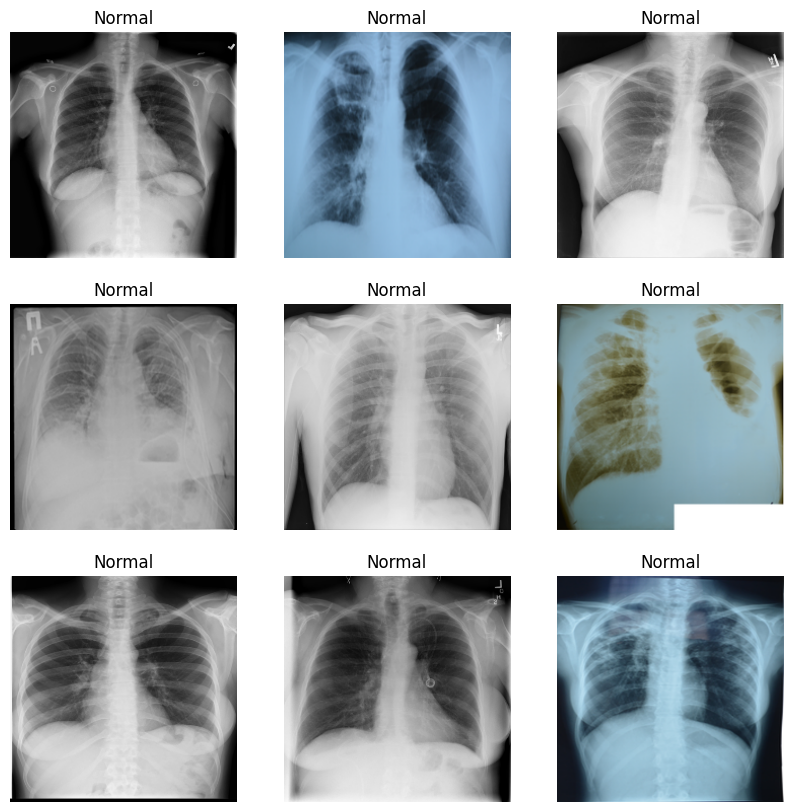

In [ ]:
import matplotlib.pyplot as plt
class_names = ds_train.class_names
plt.figure(figsize=(10,10))
for images, labels in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = np.argmax(labels[i].numpy())
        class_name = class_names[label]
        plt.title(class_name)
        plt.axis("off")
plt.show()

In [ ]:
# import keras_cv



#Data Augmentation
#soft augmentation
data_augment_layers = [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
]



#Hard augmentation
# rand Augmenat
# rand_data_augment_layers = keras_cv.Layers.RandAugment(
#     value_range = (0,255),
#     augmentations_per_image = 3,
#     magnitude = 0.5,
#     magnitude_stddev = 0.15,
#     rate = 0.9090909090909091,
#     geometric = True,
#     seed = None,
# )


def data_augment(images):
    for layer in data_augment_layers:
        images = layer(images)
    return images


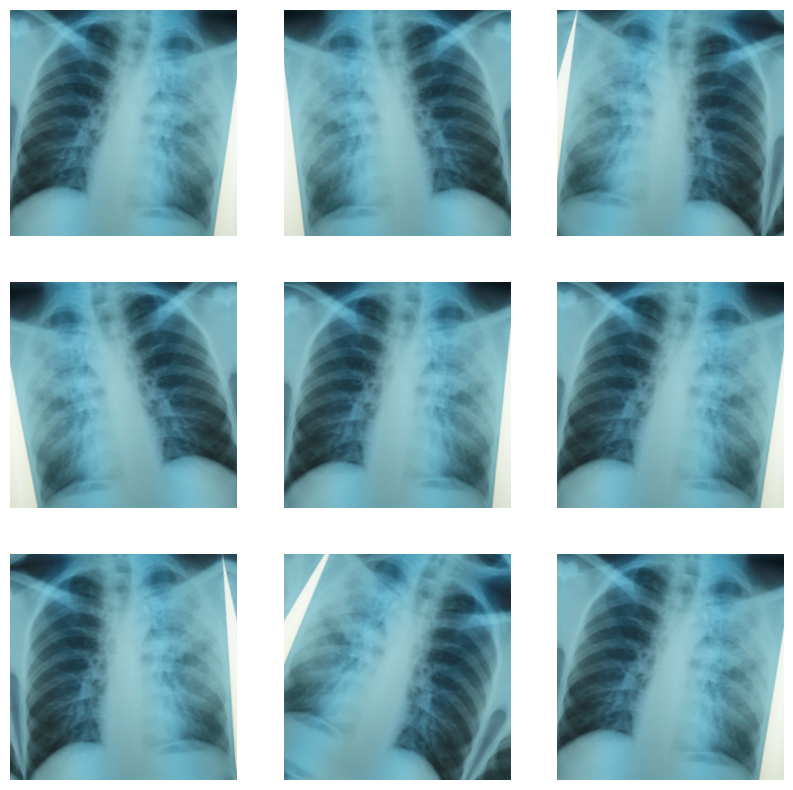

In [ ]:
#Plotting augmented images
plt.figure(figsize=(10,10))
for images, _ in ds_train.take(1):
    for i in range(9):
        augmented_images = data_augment(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [7]:
# using gaussian noise for image noising
def add_gaussian_noise(image):
    #add Guassian noise to an image
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
    noisy_image = image + noise
    return tf.clip_by_value(noisy_image, 0.0,1.0)# ensuring the image is still in [0,1]

def prepare_dataset(images, labels, training=False):
    #rescale images from [0,255] to [0,1 ] and add noise if training
    images = tf.cast(images, tf.float32) / 255.0
    if training:
        images = add_gaussian_noise(images)
    return images, labels

#Apply the preprocessing function with noise addition
ds_train = ds_train.map(lambda x, y: prepare_dataset(x, y, training=False))
ds_val = ds_val.map(lambda x, y: prepare_dataset(x, y, training=False))
ds_test = ds_test.map(lambda x, y: prepare_dataset(x, y, training=False))

In [ ]:
ds_train

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

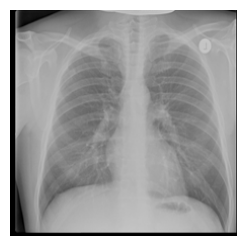

In [ ]:
#plotting noised images
def plot_images(dataset, num_images=9):
    plt.figure(figsize=(10,10))
    for images, _ in dataset.take(1): #take one batch from the dataset
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy())
        plt.axis("off")
    plt.show()
#plotting images with noise
plot_images(ds_train)

In [ ]:
# #Handling Class imbalance
# from sklearn.utils import class_weight
# labels = np.concatenate([y for x, y in ds_train], axis=0)

# class_weights = class_weight.compute_class_weight(
#     class_weight = "balanced",
#     classes = np.unique(np.argmax(labels, axis=1)),
#     y = np.argmax(labels, axis=1)
# )
# class_weights = dict(enumerate(class_weights))
# class_weights

In [ ]:
# #VGG16 architecture

# #input layer
# inputs = tf.keras.layers.Input(shape=(224, 224, 3))
# x = inputs
# #Convolutional Blocks
# for i, filters in enumerate([64, 128, 256, 512, 512]):
#     if i < 2:
#         x = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(x)
#         x = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(x)
#     else:
#         x = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding='same', activation="relu")(x)
#         x = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(x)
#         x = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
#     x = tf.keras.layers.Dropout(0.5)(x)

# # Fully Connected Layers

# x = tf.keras.layers.Flatten()(x)
# # x = tf.keras.layers.Dense(4096, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(64, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.5)(x)

# outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# model.summary()


In [ ]:
# import keras.backend as K

# # channel and spatial Attention functions
# def channel_attention(input_feature, ratio=8):
#     channel = input_feature.shape[-1]
#     shared_layer_one = tf.keras.layers.Dense(channel//ratio, activation='relu', kernel_initializer="he_normal", use_bias=True, bias_initializer="zeros")
#     shared_layer_two = tf.keras.layers.Dense(channel, kernel_initializer="he_normal", use_bias=True, bias_initializer="zeros")

#     avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_feature)
#     avg_pool = shared_layer_one(avg_pool)
#     avg_pool = shared_layer_two(avg_pool)

#     max_pool = tf.keras.layers.GlobalMaxPooling2D()(input_feature)
#     max_pool = shared_layer_one(max_pool)
#     max_pool = shared_layer_two(max_pool)

#     cbam_feature = tf.keras.layers.Add()([avg_pool, max_pool])
#     cbam_feature = tf.keras.layers.Activation("sigmoid")(cbam_feature)

#     return tf.keras.layers.Multiply()([input_feature, cbam_feature])

# def spatial_attention(input_feature):
#     kernel_size=7
#     avg_pool = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(input_feature)
#     max_pool = tf.keras.layers.Lambda(lambda x: K.max(x, axis=3, keepdims=True))(input_feature)
#     concat = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])
#     cbam_feature = tf.keras.layers.Conv2D(filters=1, kernel_size=kernel_size, activation="sigmoid", padding="same", kernel_initializer="he_normal", use_bias=False)(concat)
#     return tf.keras.layers.Multiply()([input_feature, cbam_feature])


# #input layer
# inputs = tf.keras.layers.Input(shape=(224,224,3))
# x = inputs

# #Convolutional Block
# for i, filters in enumerate([64, 128, 256, 512, 512]):
#     if i < 2:
#         x = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(x)
#         x = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(x)

#     else:
#         x = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(x)
#         x = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(x)
#         x = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(x)
#     x = tf.keras.layers.Dropout(0.5)(x)

# #Attention Block
# x = channel_attention(x)
# x = spatial_attention(x)

# #Fully connected Layer
# x = tf.keras.layers.Flatten()(x)
# # x = tf.keras.layers.Dropout(0.5)(x)
# # x = tf.keras.layers.Dense(64, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(64, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.5)(x)

# #output Layer
# outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# model.summary()




In [ ]:
# import keras.backend as K

# # channel and spatial Attention functions
# def channel_attention(input_feature, ratio=8):
#     channel = input_feature.shape[-1]
#     shared_layer_one = tf.keras.layers.Dense(channel//ratio, activation='relu', kernel_initializer="he_normal", use_bias=True, bias_initializer="zeros")
#     shared_layer_two = tf.keras.layers.Dense(channel, kernel_initializer="he_normal", use_bias=True, bias_initializer="zeros")

#     avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_feature)
#     avg_pool = shared_layer_one(avg_pool)
#     avg_pool = shared_layer_two(avg_pool)

#     max_pool = tf.keras.layers.GlobalMaxPooling2D()(input_feature)
#     max_pool = shared_layer_one(max_pool)
#     max_pool = shared_layer_two(max_pool)

#     cbam_feature = tf.keras.layers.Add()([avg_pool, max_pool])
#     cbam_feature = tf.keras.layers.Activation("sigmoid")(cbam_feature)

#     return tf.keras.layers.Multiply()([input_feature, cbam_feature])

# def spatial_attention(input_feature):
#     kernel_size=7
#     avg_pool = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(input_feature)
#     max_pool = tf.keras.layers.Lambda(lambda x: K.max(x, axis=3, keepdims=True))(input_feature)
#     concat = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])
#     cbam_feature = tf.keras.layers.Conv2D(filters=1, kernel_size=kernel_size, activation="sigmoid", padding="same", kernel_initializer="he_normal", use_bias=False)(concat)
#     return tf.keras.layers.Multiply()([input_feature, cbam_feature])


# #input layer
# inputs = tf.keras.layers.Input(shape=(224,224,3))
# x = inputs

# #Convolutional Block
# for i, filters in enumerate([64, 128, 256, 512, 512]):
#     if i < 2:
#         x = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(x)
#         x = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(x)

#     else:
#         x = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(x)
#         x = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(x)
#         x = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(x)
#     #Attention Block
#     x = channel_attention(x)
#     x = spatial_attention(x)
#     #conv layers continued
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(x)
#     x = tf.keras.layers.Dropout(0.5)(x)


# #Fully connected Layer
# x = tf.keras.layers.Flatten()(x)
# # x = tf.keras.layers.Dropout(0.5)(x)
# # x = tf.keras.layers.Dense(64, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(64, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.5)(x)

# #output Layer
# outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# model.summary()




In [ ]:
# from google.colab import files

# uploaded = files.upload()


In [8]:
import sys
sys.path.append('/content/drive/MyDrive/TB')


In [21]:
pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 56.4 MB/s eta 0:00:00


In [22]:
import importlib
import model_update
importlib.reload(model_update)
from model_update import get_model
import keras_cv


Using TensorFlow backend


In [23]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
%autoreload 2
from model_update import get_model
model = get_model("mobilenet", (img_shape,img_shape,3), num_classes = 2, augment=False, all_trainable=True, attention="None")

17225924/17225924 [==============================] - 2s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_max_pooling2d_2 (Gl  (None, 1024)              0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                            

In [30]:
#model compile

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-5,
#     decay_steps=10000,
#     decay_rate=0.9)
# optimizer = keras.optimizers.SGD(learning_rate=lr_schedule

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
             loss = tf.keras.losses.BinaryCrossentropy(),
             metrics=["accuracy"])

In [31]:
import datetime
import PIL
#Callbacks
model_folder ="/content/drive/MyDrive/savemoddel "
log_dir = f"logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(f"{model_folder}/TB_model.h5", save_best_only=True, save_weights_only=True, monitor="val_loss", mode = "min", verbose=1)
early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1, restore_best_weights=True)
callbacks = [tensorboard_cb, checkpoint_cb, early_stop_cb]

In [32]:
#Fitting the model
history = model.fit(
    ds_train,
    validation_data = ds_val,
    batch_size=batch_size,
    verbose=1,
    epochs=1000,
#     class_weights = class_weights,
    callbacks = callbacks
)

Epoch 1/1000
175/175 [==============================] - ETA: 0s - loss: 0.8567 - accuracy: 0.7957
Epoch 1: val_loss improved from inf to 0.14247, saving model to /content/drive/MyDrive/savemoddel /TB_model.h5
175/175 [==============================] - 41s 155ms/step - loss: 0.8567 - accuracy: 0.7957 - val_loss: 0.1425 - val_accuracy: 0.9650
Epoch 2/1000
174/175 [============================>.] - ETA: 0s - loss: 0.1169 - accuracy: 0.9585
Epoch 2: val_loss improved from 0.14247 to 0.08119, saving model to /content/drive/MyDrive/savemoddel /TB_model.h5
175/175 [==============================] - 24s 136ms/step - loss: 0.1167 - accuracy: 0.9586 - val_loss: 0.0812 - val_accuracy: 0.9800
Epoch 3/1000
174/175 [============================>.] - ETA: 0s - loss: 0.0446 - accuracy: 0.9847
Epoch 3: val_loss did not improve from 0.08119
175/175 [==============================] - 24s 131ms/step - loss: 0.0446 - accuracy: 0.9848 - val_loss: 0.0950 - val_accuracy: 0.9800
Epoch 4/1000
174/175 [=========

In [33]:
#test inference
test_loss, test_accuracy = model.evaluate(ds_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

7/7 [==============================] - 1s 67ms/step - loss: 0.0034 - accuracy: 1.0000
Test Loss: 0.0034035707358270884
Test Accuracy: 1.0


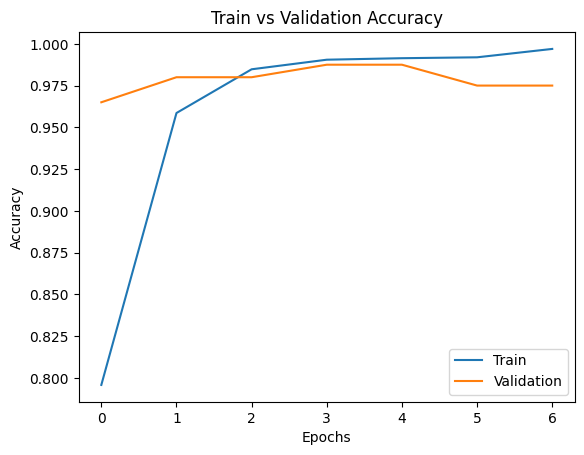

In [34]:
#plotting the train and val accuracy curve
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Train vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', "Validation"])
plt.show()

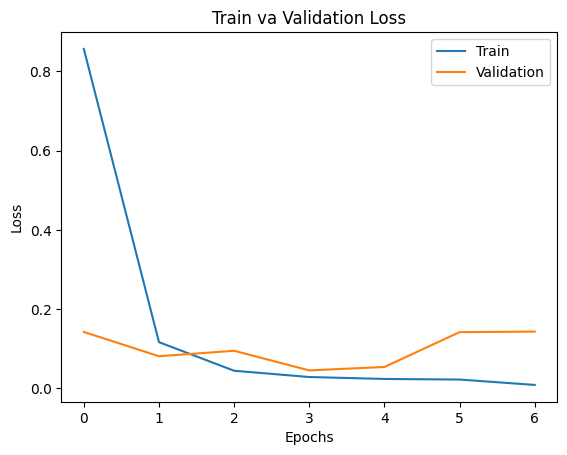

In [35]:
#plotting the train and val_accuracy loss curve

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Train va Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.show()

In [ ]:
# #Confusion Matrix adn classification report
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns

# # class_name = ds_test.class_names

# class_name = ["Healthy", "Tuberculosis"]

# y_true = np.concatenate([y for x, y in ds_test], axis=0)
# y_pred = model.predict(ds_test)


# unique_classes = np.unique(y_true)
# print("Unique classes in y_true:", unique_classes)


# y_true = np.argmax(y_true, axis=1)
# unique_classes = np.unique(y_true)
# print("Unique classes in y_true:", unique_classes)

# y_pred = np.argmax(y_pred, axis=1)
# unique_pred_classes = np.unique(y_pred)
# print("Unique classes in y_pred:", unique_pred_classes)

# cm = confusion_matrix(y_true, y_pred)

# plt.figure(figsize=(10,8))
# sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=class_name, yticklabels=class_name)
# plt.xlabel("Predicted labels")
# plt.ylabel("True labels")
# plt.title("Confusion Matrix")
# plt.show()


# #classification report
# report = classification_report(y_true, y_pred, target_names=class_name)
# print(report)

7/7 [==============================] - 1s 66ms/step


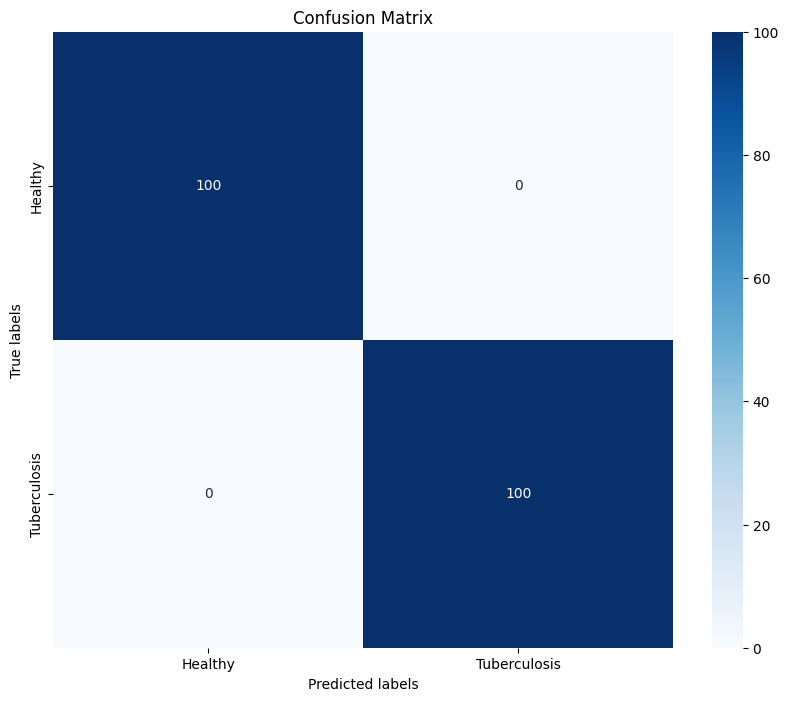

              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       100
Tuberculosis       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [36]:
# Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming `ds_test` is your dataset and `model` is your trained model
class_names = ["Healthy", "Tuberculosis"]

# Gather true labels and predictions
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_pred = model.predict(ds_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)



Class distribution in labels: {0: 200}


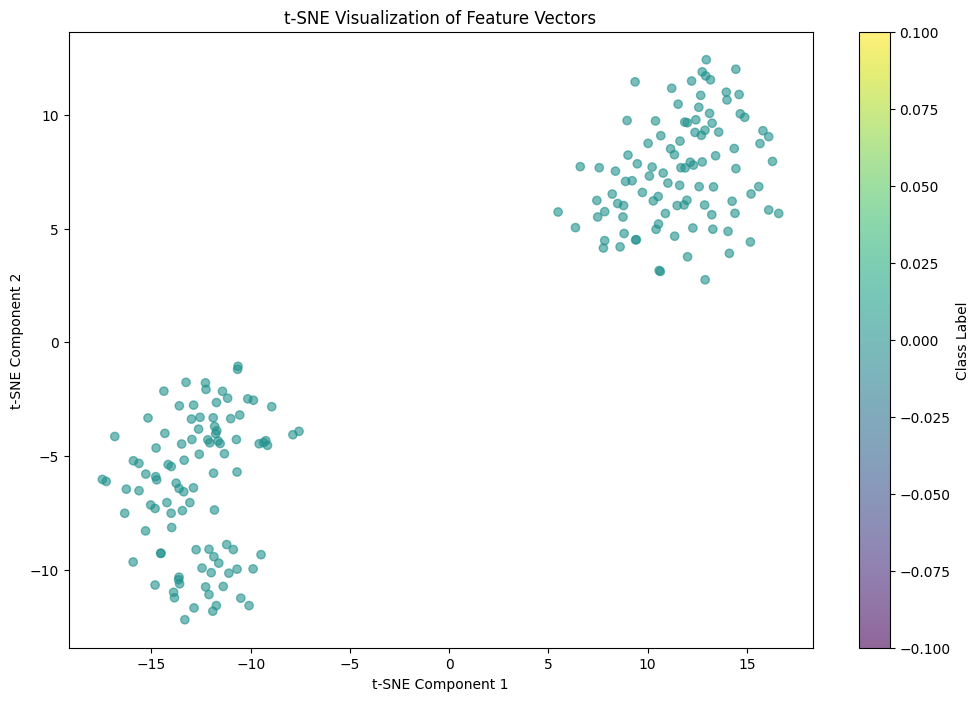

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf

# Assuming `model` is your trained model and `ds_test` is your test dataset

# Get the number of layers
n_layers = len(model.layers)

# Create a feature extraction model
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[n_layers - 2].output)

# Extract features and labels
features = []
labels = []
for x, y in ds_test:
    features.append(feature_extractor(x, training=False))  # Use the model in inference mode
    labels.append(y)

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Check class distribution in labels
unique, counts = np.unique(np.argmax(labels, axis=1), return_counts=True)
print("Class distribution in labels:", dict(zip(unique, counts)))

# Apply t-SNE on the extracted features
features_embedded = TSNE(n_components=2, random_state=42).fit_transform(features)

# Plot the features in a 2D space
plt.figure(figsize=(12, 8))
scatter = plt.scatter(features_embedded[:, 0], features_embedded[:, 1], c=np.argmax(labels, axis=1), cmap="viridis", alpha=0.6)

# Create a color bar with labels
colorbar = plt.colorbar(scatter)
colorbar.set_label('Class Label')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Feature Vectors")
plt.show()



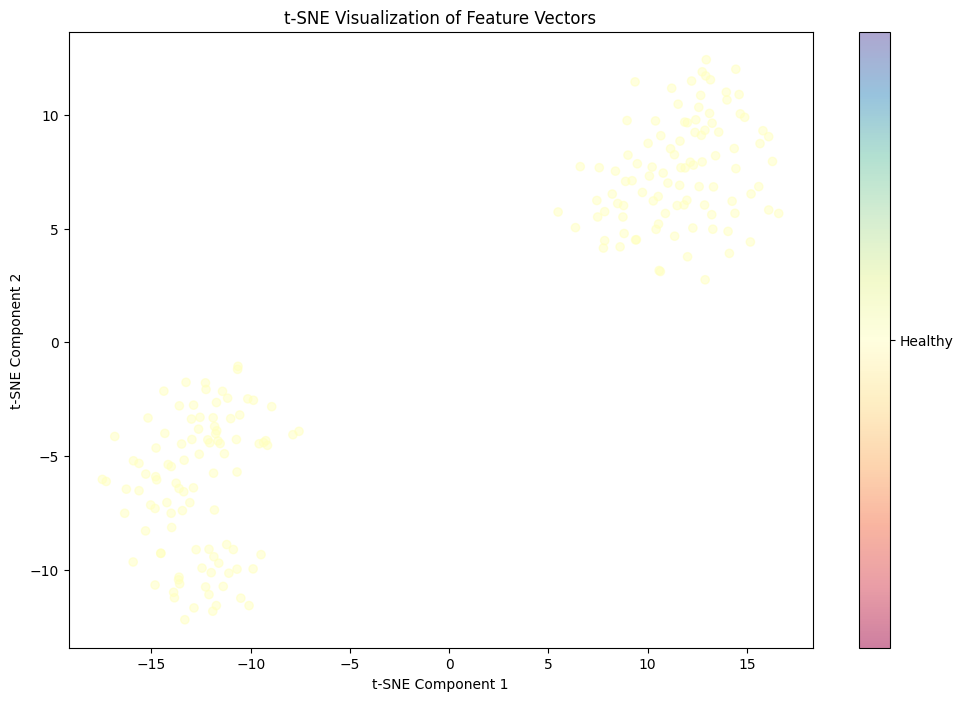

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf

# Assuming `model` is your trained model and `ds_test` is your test dataset

# Extract the second-to-last layer of the model as feature representations
n_layers = len(model.layers)
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[n_layers-2].output)

# Extract features from the dataset using the feature extractor
features = []
labels = []
for x, y in ds_test:
    features.append(feature_extractor(x, training=False))  # Set training=False to use the model in inference mode
    labels.append(y)

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Apply t-SNE on the extracted features
features_embedded = TSNE(n_components=2, random_state=42).fit_transform(features)

# Get unique class labels for coloring in the plot
unique_labels = np.unique(labels)
class_names = ["Healthy", "Tuberculosis"]  # Assuming you have class names

# Plot the features in a 2D space
plt.figure(figsize=(12, 8))
scatter = plt.scatter(features_embedded[:, 0], features_embedded[:, 1], c=np.argmax(labels, axis=1), cmap="Spectral", alpha=0.5)

# Create a color bar with the class names
colorbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
colorbar.set_ticklabels(class_names)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Feature Vectors")
plt.show()


In [39]:
# T-sne  chart Plotting
from sklearn.manifold import TSNE

#Get the total number of layers
n_layers = len(model.layers)

#extract the feature

feature_extract = tf.keras.Model(inputs=model.inputs, ouputs=model.layers[n_layers-2].output)

#extract labels from the test dataset
test_labels = np.concatenate([y for x, y in ds_test], axis=0)

#apply t-sne on the extracted features
features_embedded = TSNE(n_components=2).fittransform(features)

#get unique class labels
unique_labels = np.unique(test_labels)

#plot the features in a 2D space

#specify the class labels(indices) as colors using the "c" parameter
plt.scatter(feature_embedded[:, 0], features_embedded[:, 1], c= np.argmax(labels, axis=1), cmap="Spectral", alpha=0.5)

#add a colobar to display the legend
colorbar = plt.colorbar(ticks=unique_labels)
colorbar.set_ticklabels(unique_labels)
plt.show()

TypeError: ('Keyword argument not understood:', 'ouputs')